README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

train.tar:   0%|          | 0.00/143M [00:00<?, ?B/s]

val.tar:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6394 [00:00<?, ? examples/s]

aquamonitor-jyu.parquet.gzip:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

2_2-B6-Ch-ala1-6_1_2023_07_05-12-24-06-895
Train Size: 40880
eval Size: 6394


Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 184MB/s]


Epoch [1/6], lr: 0.0001, Train Loss: 0.9978, Train F1-Score: 0.884, eval Loss: 1.3306, eval F1-Score: 0.769
Epoch [2/6], lr: 0.0001, Train Loss: 0.7251, Train F1-Score: 0.978, eval Loss: 1.4744, eval F1-Score: 0.75
Epoch [3/6], lr: 0.0001, Train Loss: 0.7099, Train F1-Score: 0.983, eval Loss: 1.4290, eval F1-Score: 0.757
Epoch [4/6], lr: 0.0001, Train Loss: 0.6902, Train F1-Score: 0.988, eval Loss: 1.5646, eval F1-Score: 0.728
Epoch [5/6], lr: 0.0001, Train Loss: 0.6863, Train F1-Score: 0.989, eval Loss: 1.6330, eval F1-Score: 0.714
Epoch [6/6], lr: 0.0001, Train Loss: 0.6868, Train F1-Score: 0.988, eval Loss: 1.5035, eval F1-Score: 0.742


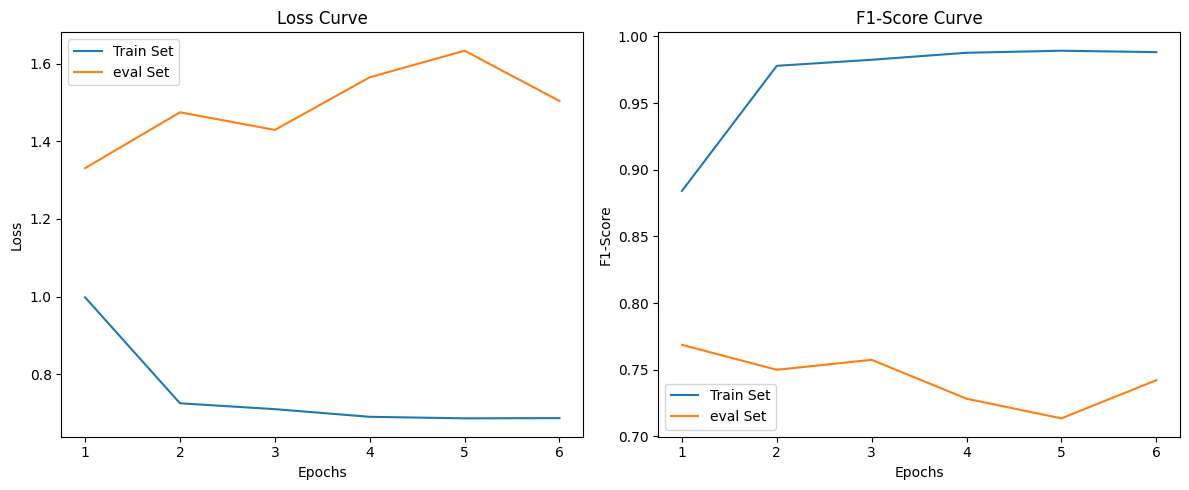

In [1]:
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from sklearn.metrics import f1_score
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import swin_v2_t, Swin_V2_T_Weights

ds = load_dataset(
    "mikkoim/aquamonitor-jyu",
    cache_dir="/kaggle/working/"
)

hf_hub_download(
    repo_id="mikkoim/aquamonitor-jyu",
    filename="aquamonitor-jyu.parquet.gzip",
    repo_type="dataset",
    local_dir="/kaggle/working/"
)

# dataset elements can be accessed with indices. Each "row" or record
# has an image and a key that can be used to access data from the metadata table
record = ds["train"][21015]
record

img = record["jpg"]
print(record["__key__"])
img

# The keys match the rows in the metadata table
metadata = pd.read_parquet("/kaggle/working/aquamonitor-jyu.parquet.gzip")
metadata

classes = sorted(metadata["taxon_group"].unique())
class_map = {k:v for v,k in enumerate(classes)}
class_map_inv = {v:k for k,v in class_map.items()}

metadata["img"] = metadata["img"].str.removesuffix(".jpg")
label_dict = dict(zip(metadata["img"], metadata["taxon_group"].map(class_map)))

class_map_inv

IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCH_NUM = 6

tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess(batch):
    return {"key": batch["__key__"],
            "img": [tf(x) for x in batch["jpg"]],
            "label": torch.as_tensor([label_dict[x] for x in batch["__key__"]], dtype=torch.long)}

train_ds = ds["train"].with_transform(preprocess)
eval_ds = ds["validation"].with_transform(preprocess)

print(f"Train Size: {train_ds.num_rows}")
print(f"eval Size: {eval_ds.num_rows}")

# plt.imshow(train_ds[2014]["img"].permute(1, 2, 0).numpy())

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

eval_loader = DataLoader(
    eval_ds,
    batch_size=BATCH_SIZE
)

model = swin_v2_t(weights = Swin_V2_T_Weights.DEFAULT)

in_features = model.head.in_features
model.head = nn.Linear(in_features, 31)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.75,
    patience=5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialise objects to store results
train_losses = []
train_f1s = []
eval_losses = []
eval_f1s = []
best_loss = float('inf')
best_model_weights = None

for epoch in range(EPOCH_NUM):
    model.train()
    running_loss = 0.0
    train_labels = []
    train_preds = []

    for batch in train_loader:
        images, labels = batch["img"], batch["label"]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs.data, 1)
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(preds.cpu().numpy())

    # Calculate and store training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

    # Validation phase
    model.eval()
    eval_running_loss = 0.0
    eval_labels = []
    eval_preds = []

    with torch.no_grad():
        for batch in eval_loader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            eval_running_loss += loss.item()

            # Calculate validation F1 score
            _, preds = torch.max(outputs.data, 1)
            eval_labels.extend(labels.cpu().numpy())
            eval_preds.extend(preds.cpu().numpy())

    # Calculate and store validation loss and accuracy
    eval_loss = eval_running_loss / len(eval_loader)
    eval_f1 = f1_score(eval_labels, eval_preds, average='weighted')
    eval_losses.append(eval_loss)
    eval_f1s.append(eval_f1)

    # Step the scheduler
    scheduler.step(eval_loss)

    print(f'Epoch [{epoch+1}/{EPOCH_NUM}], lr: {scheduler.get_last_lr()[0]}, '
          f'Train Loss: {train_loss:.4f}, Train F1-Score: {train_f1:.3g}, '
          f'eval Loss: {eval_loss:.4f}, eval F1-Score: {eval_f1:.3g}')

    # Check if we have a new best model
    if eval_loss < best_loss:
        best_loss = eval_loss
        best_model_weights = model.state_dict()

# Restore best weights
if best_model_weights is not None:

    # Load best model
    model.load_state_dict(best_model_weights)
    # Save best model
    torch.save(best_model_weights, '/kaggle/working/fine_tuned_swin.pth')

# Plot the learning curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCH_NUM + 1), train_losses, label='Train Set')
plt.plot(range(1, EPOCH_NUM + 1), eval_losses, label='eval Set')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# F1-Score plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCH_NUM + 1), train_f1s, label='Train Set')
plt.plot(range(1, EPOCH_NUM + 1), eval_f1s, label='eval Set')
plt.title('F1-Score Curve')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()